[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLO11 Instance Segmentation on a Custom Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)

YOLO11 builds on the advancements introduced in YOLOv9 and YOLOv10 earlier this year, incorporating improved architectural designs, enhanced feature extraction techniques, and optimized training methods.

YOLO11m achieves a higher mean mAP score on the COCO dataset while using 22% fewer parameters than YOLOv8m, making it computationally lighter without sacrificing performance.

YOLOv11 is available in 5 different sizes, ranging from `2.6M` to `56.9M` parameters, and capable of achieving from `39.5` to `54.7` mAP on the COCO dataset.

## Setup

### Configure API keys

To fine-tune YOLO11, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Tue Jun 10 09:54:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [4]:
%pip install "ultralytics<=8.3.40" supervision roboflow
# prevent ultralytics from tracking your activity
!yolo settings sync=False
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.8/112.6 GB disk)


## Inference with model pre-trained on COCO dataset

### CLI

**NOTE:** CLI requires no customization or Python code. You can simply run all tasks from the terminal with the yolo command.

In [5]:
!yolo task=detect mode=predict model=yolo11l-seg.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

100% 53.5M/53.5M [00:01<00:00, 42.9MB/s]
WARNING ⚠️ conflicting 'task=detect' passed with 'task=segment' model. Ignoring 'task=detect' and updating to 'task=segment' to match model.
Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l-seg summary (fused): 491 layers, 27,646,272 parameters, 0 gradients, 142.2 GFLOPs

100% 104k/104k [00:00<00:00, 92.4MB/s]
image 1/1 /content/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 1 backpack, 109.8ms
Speed: 13.0ms preprocess, 109.8ms inference, 450.1ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/segment/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


**NOTE:** Result annotated image got saved in `{HOME}/runs/detect/predict/`. Let's display it.

In [7]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/segment/predict/dog.jpeg', width=600)

FileNotFoundError: [Errno 2] No such file or directory: '/content/runs/segment/predict/dog.jpeg'

### SDK

**NOTE:** YOLO's Python interface allows for seamless integration into your Python projects, making it easy to load, run, and process the model's output.

In [8]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11l-seg.pt')
image = Image.open(requests.get('https://media.roboflow.com/notebooks/examples/dog.jpeg', stream=True).raw)
result = model.predict(image, conf=0.25)[0]


0: 640x384 1 person, 1 car, 1 dog, 1 backpack, 69.3ms
Speed: 2.9ms preprocess, 69.3ms inference, 162.0ms postprocess per image at shape (1, 3, 640, 384)


**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

In [9]:
result.boxes.xyxy

tensor([[0.0000e+00, 6.6552e+02, 4.4326e+02, 1.2796e+03],
        [7.1101e+01, 2.4920e+02, 6.4366e+02, 9.1943e+02],
        [1.1703e+00, 3.5331e+02, 6.2878e+02, 1.2769e+03],
        [6.2872e+02, 7.3547e+02, 6.9789e+02, 7.8725e+02]], device='cuda:0')

In [10]:
result.boxes.conf

tensor([0.9365, 0.9156, 0.8151, 0.7367], device='cuda:0')

In [11]:
result.boxes.cls

tensor([24., 16.,  0.,  2.], device='cuda:0')

In [12]:
result.masks.data

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 

**NOTE:** YOLO11 can be easily integrated with `supervision` using the familiar `from_ultralytics` connector.

In [13]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

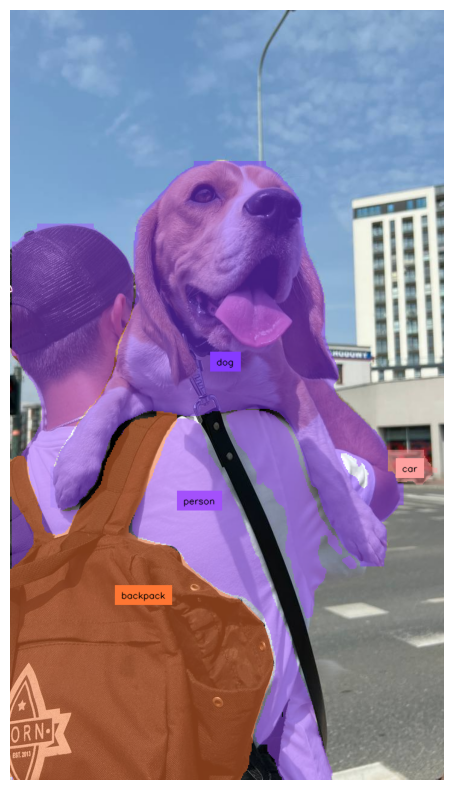

In [14]:
mask_annotator = sv.MaskAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK, text_position=sv.Position.CENTER)

annotated_image = image.copy()
annotated_image = mask_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/ks-fsm9o/pelvis-ap-x-ray) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [16]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="AyBZHtlXCdqPbCRr5ypV")
project = rf.workspace("yuvakali").project("space_debris-7figo")
version = project.version(1)
dataset = version.download("yolov11")


mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Space_Debris-1 in yolov11:: 100%|██████████| 258/258 [00:00<00:00, 7670.33it/s]


## Custom Training

In [17]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s-seg.pt data={dataset.location}/data.yaml epochs=100 imgsz=640 plots=True

/content
100% 19.7M/19.7M [00:00<00:00, 72.0MB/s]
WARNING ⚠️ conflicting 'task=detect' passed with 'task=segment' model. Ignoring 'task=detect' and updating to 'task=segment' to match model.
New https://pypi.org/project/ultralytics/8.3.152 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolo11s-seg.pt, data=/content/datasets/Space_Debris-1/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [18]:
!ls {HOME}/runs/segment/train/

args.yaml					    MaskR_curve.png
BoxF1_curve.png					    results.csv
BoxP_curve.png					    results.png
BoxPR_curve.png					    train_batch0.jpg
BoxR_curve.png					    train_batch1.jpg
confusion_matrix_normalized.png			    train_batch2.jpg
confusion_matrix.png				    train_batch630.jpg
events.out.tfevents.1749549547.b408720703b4.1718.0  train_batch631.jpg
labels_correlogram.jpg				    train_batch632.jpg
labels.jpg					    val_batch0_labels.jpg
MaskF1_curve.png				    val_batch0_pred.jpg
MaskP_curve.png					    weights
MaskPR_curve.png


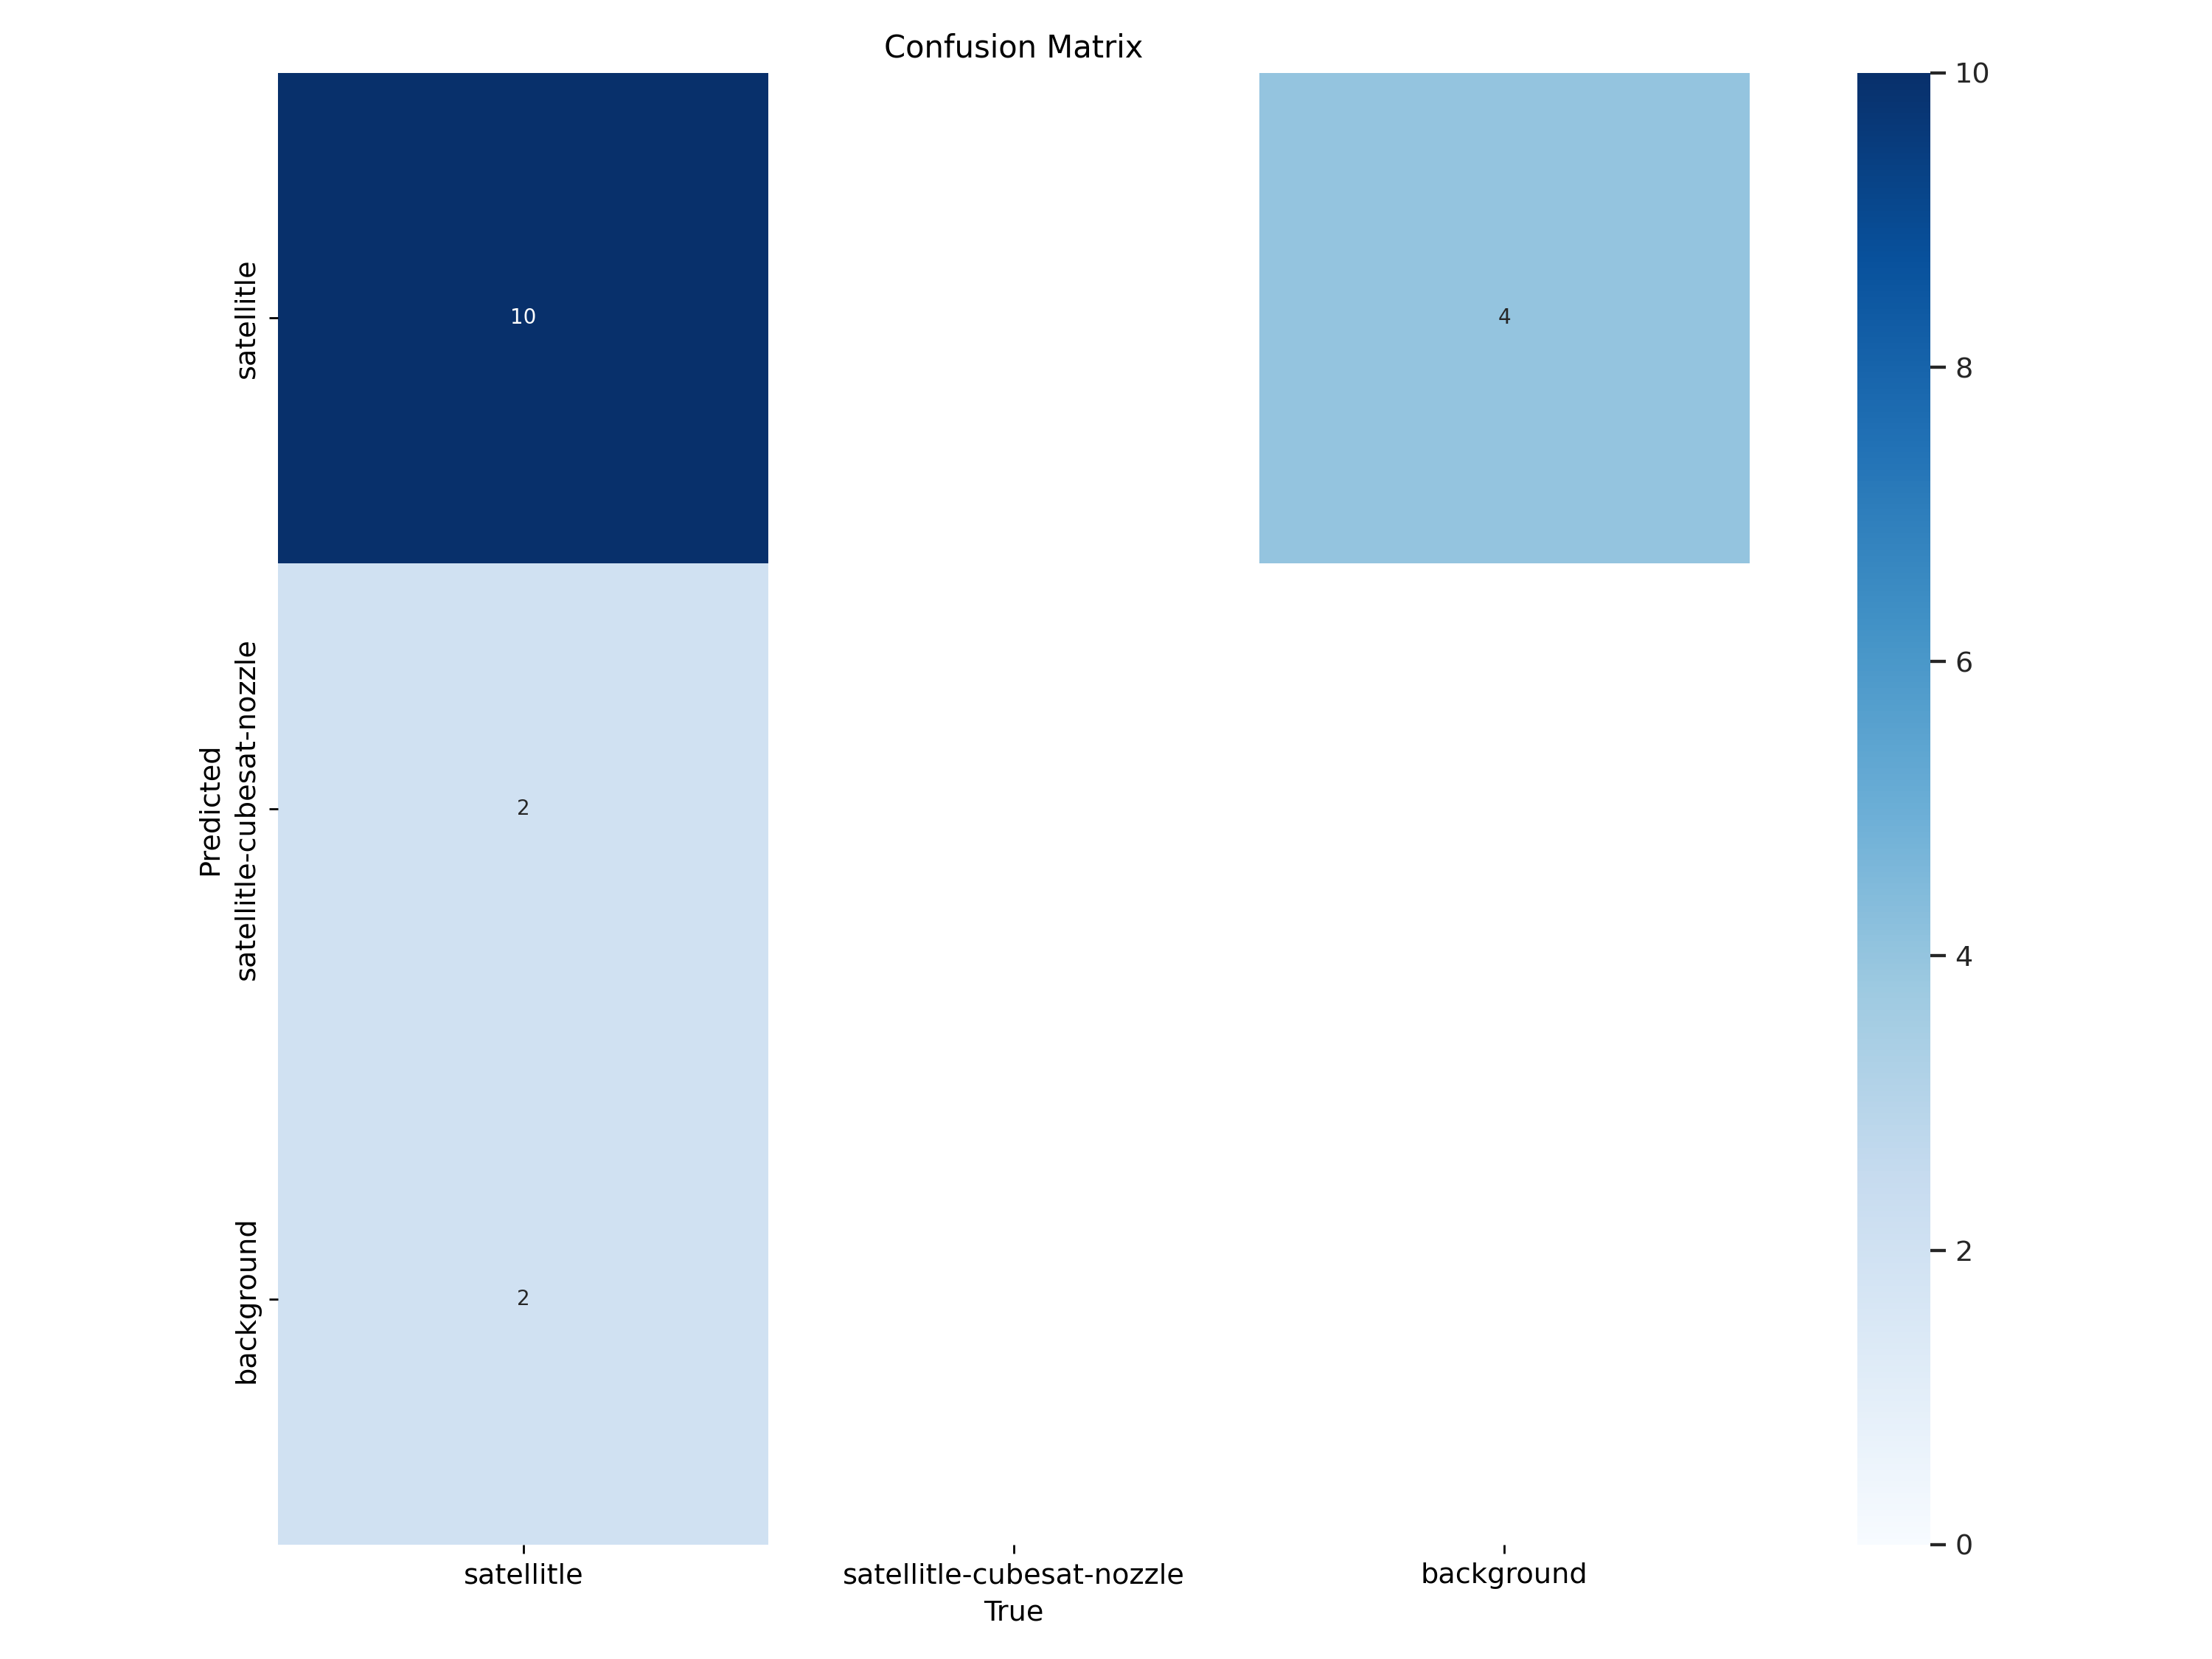

In [19]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/segment/train/confusion_matrix.png', width=600)

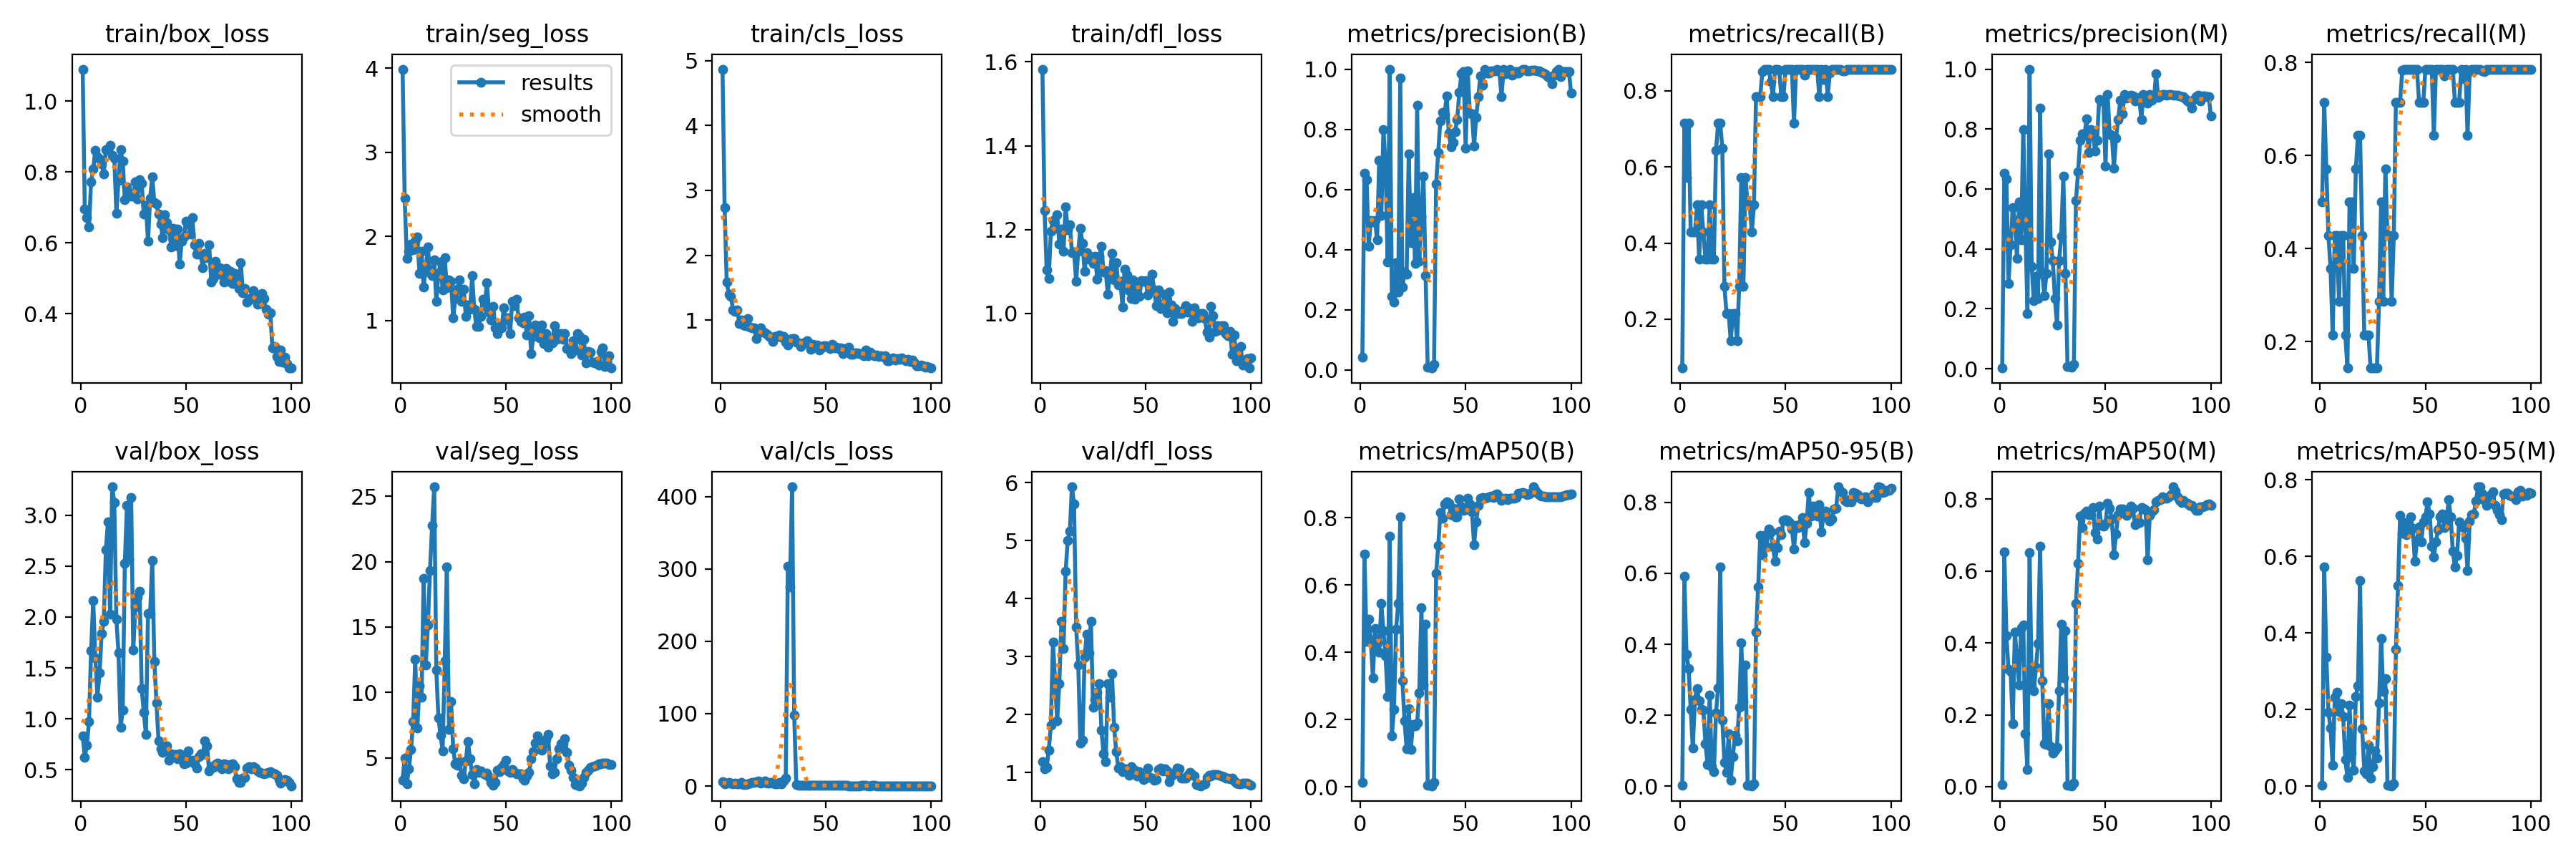

In [20]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/segment/train/results.png', width=600)

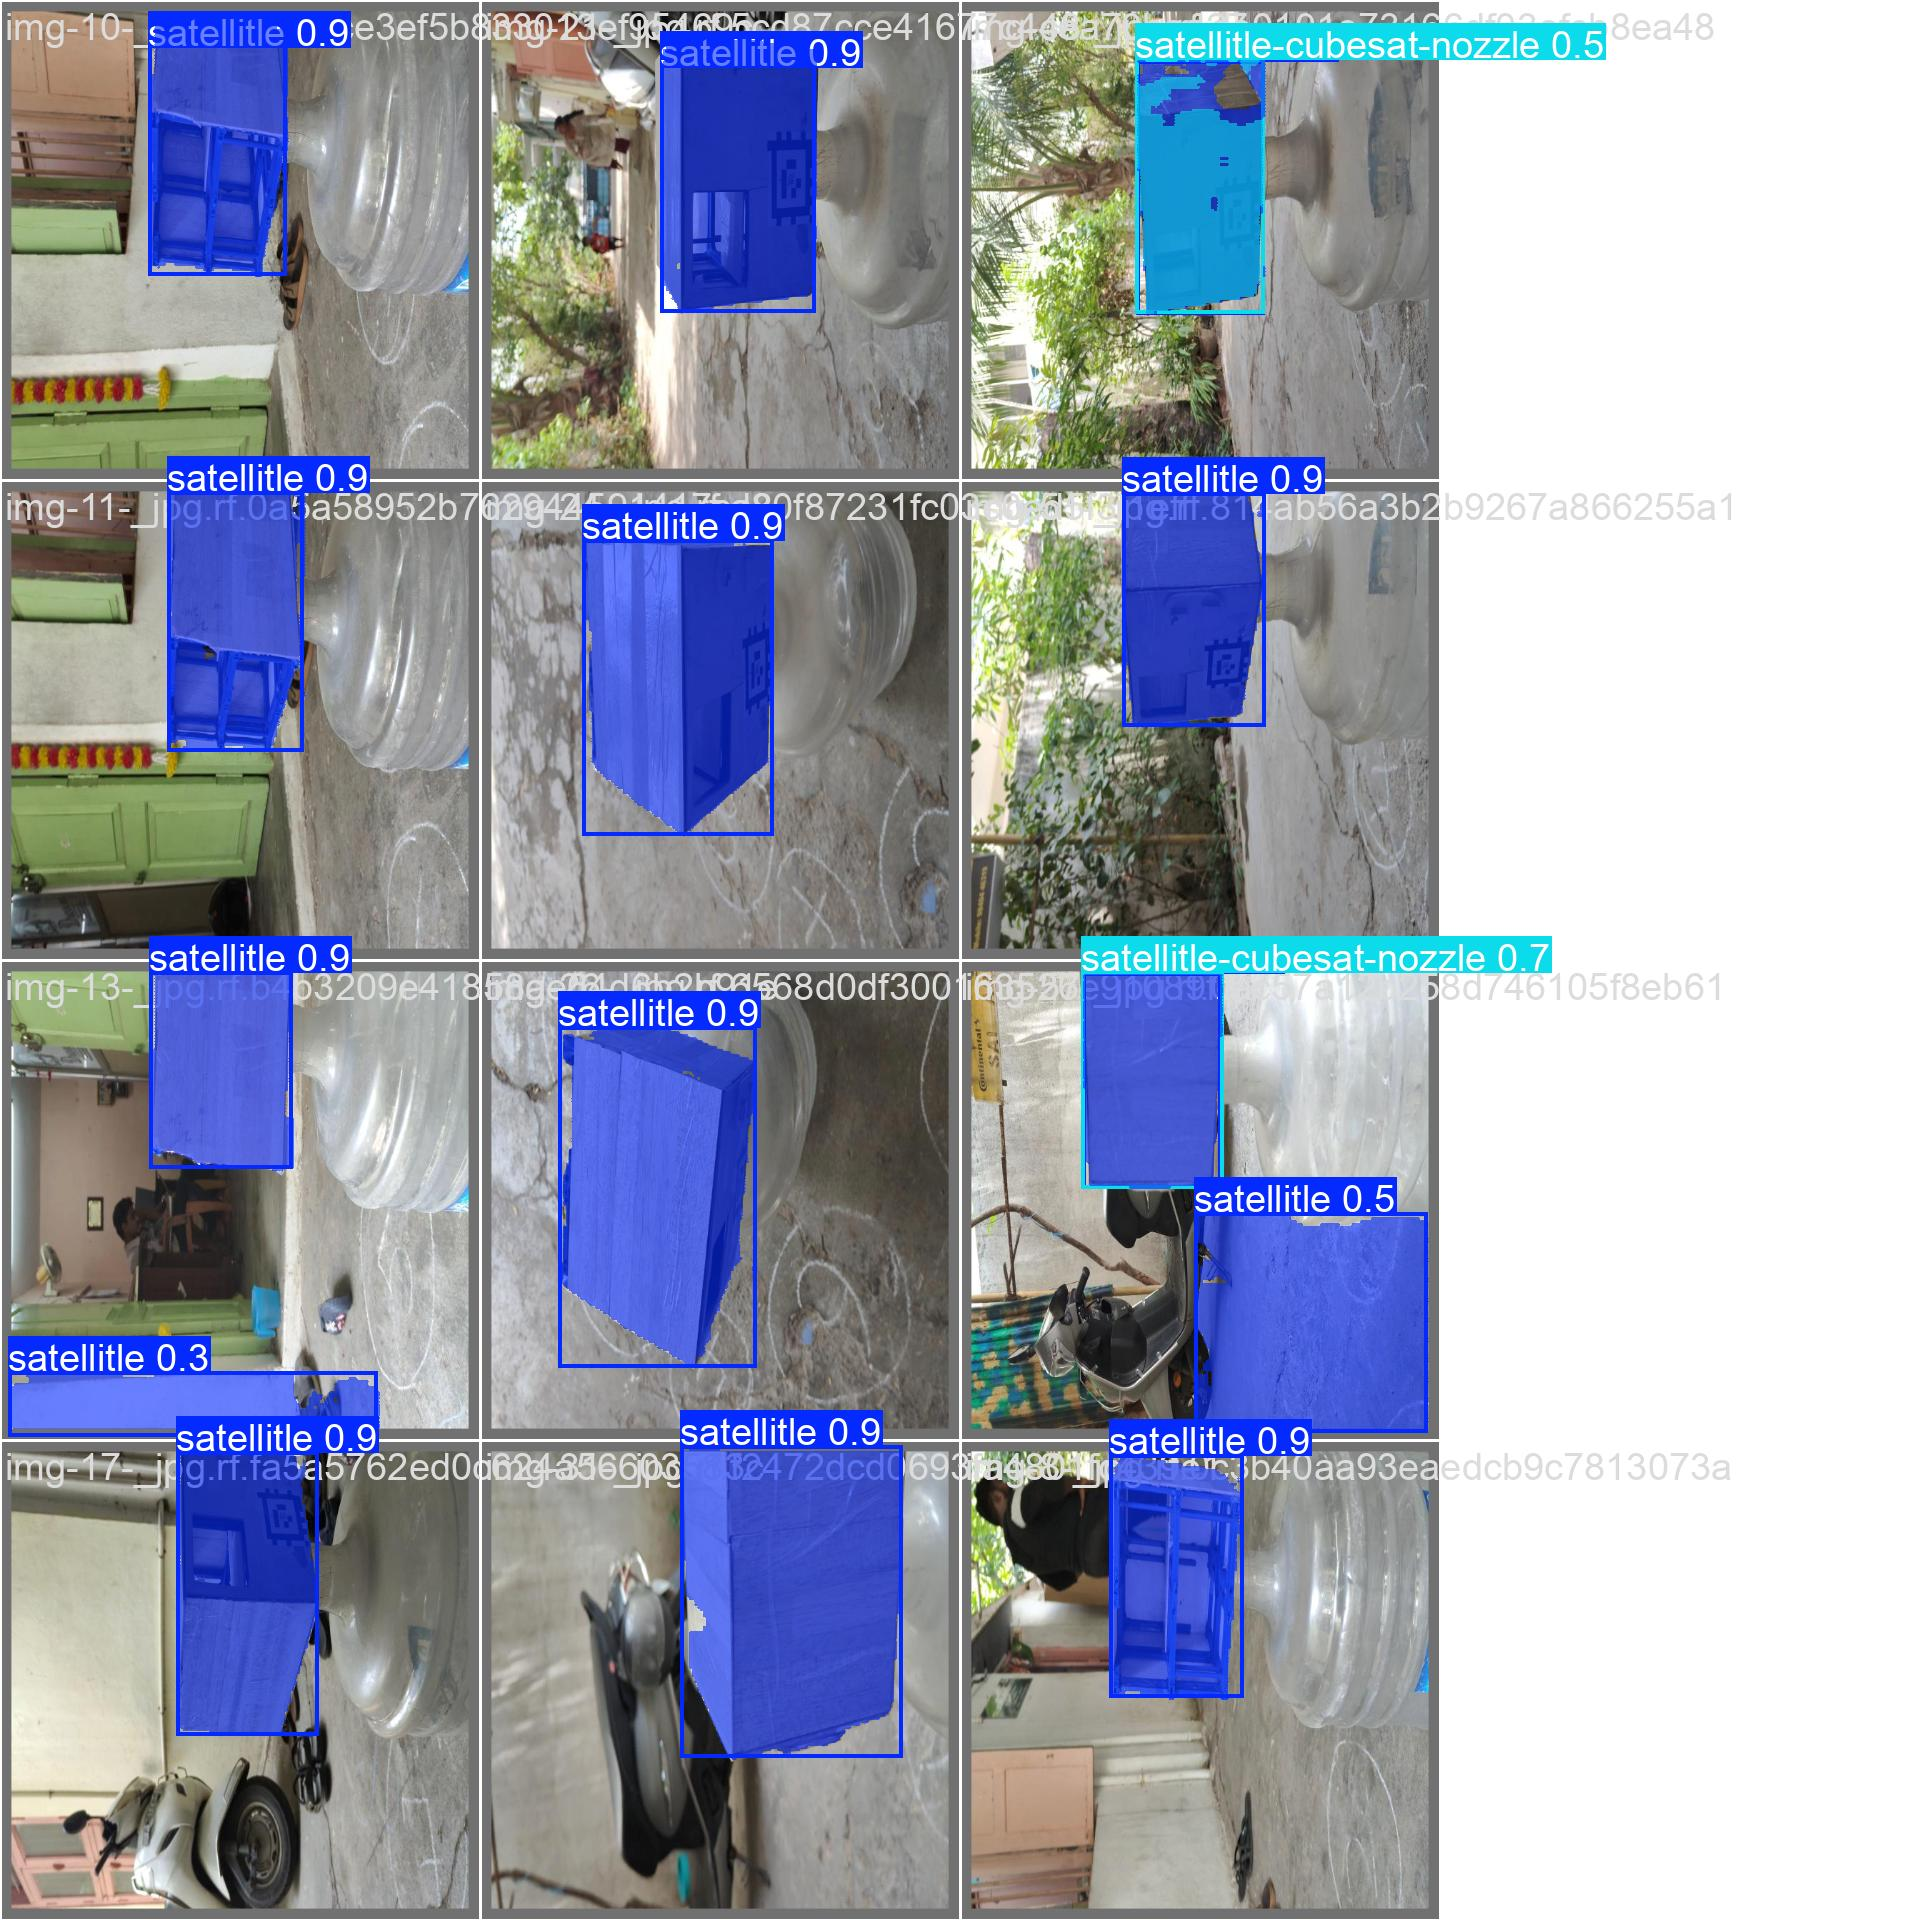

In [21]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/segment/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [22]:
!yolo task=detect mode=val model={HOME}/runs/segment/train/weights/best.pt data={dataset.location}/data.yaml

WARNING ⚠️ conflicting 'task=detect' passed with 'task=segment' model. Ignoring 'task=detect' and updating to 'task=segment' to match model.
Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-seg summary (fused): 265 layers, 10,067,590 parameters, 0 gradients, 35.3 GFLOPs
val: Scanning /content/datasets/Space_Debris-1/valid/labels.cache... 12 images, 0 backgrounds, 0 corrupt: 100% 12/12 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 1/1 [00:00<00:00,  1.85it/s]
                   all         12         14      0.988      0.857      0.873      0.844      0.905      0.786      0.798      0.782
            satellitle         12         14      0.988      0.857      0.873      0.844      0.905      0.786      0.798      0.782
Speed: 0.3ms preprocess, 19.1ms inference, 0.0ms loss, 11.4ms postprocess per image
Results saved to runs/segment/val
💡 

## Inference with custom model

In [23]:
!yolo task=detect mode=predict model={HOME}/runs/segment/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

WARNING ⚠️ conflicting 'task=detect' passed with 'task=segment' model. Ignoring 'task=detect' and updating to 'task=segment' to match model.
Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-seg summary (fused): 265 layers, 10,067,590 parameters, 0 gradients, 35.3 GFLOPs

image 1/2 /content/datasets/Space_Debris-1/test/images/img-16-_jpg.rf.384984c4f83f0b84eea20fd433367009.jpg: 640x640 2 satellitles, 20.2ms
image 2/2 /content/datasets/Space_Debris-1/test/images/img-52-_jpg.rf.f94bdd8345d721e0d1bd73dbc9e7a0b8.jpg: 640x640 1 satellitle, 1 satellitle-cubesat-nozzle, 20.2ms
Speed: 2.3ms preprocess, 20.2ms inference, 71.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/segment/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


**NOTE:** Let's take a look at few results.

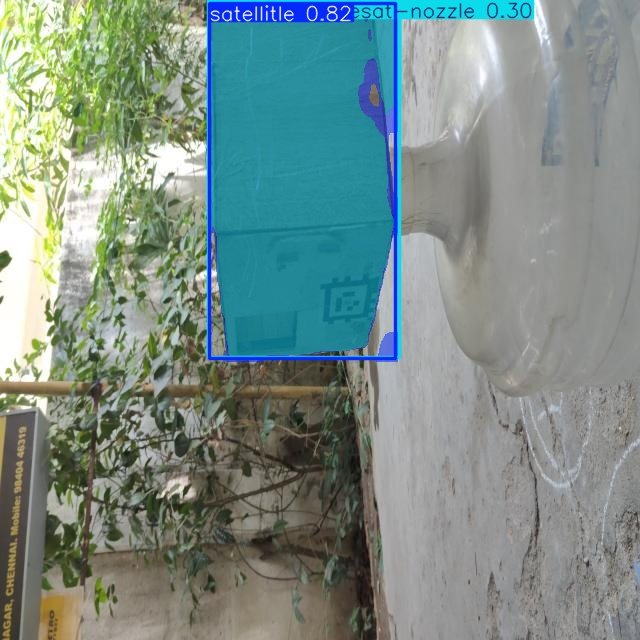

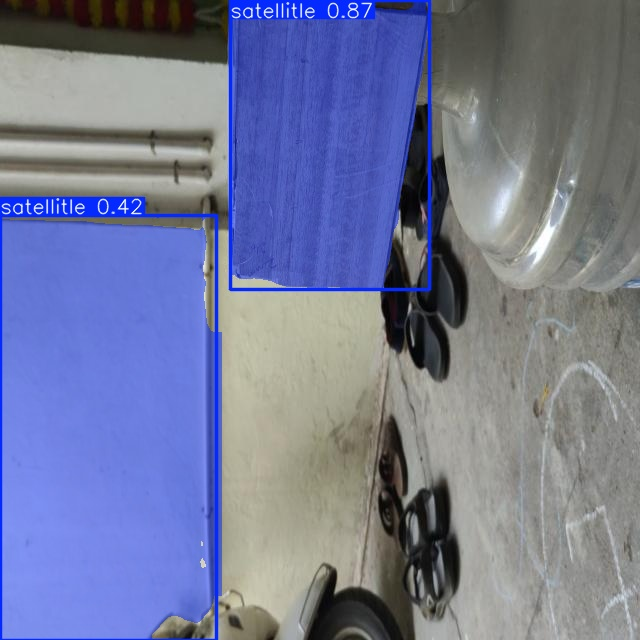

In [24]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/segment/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

In [25]:
!ls runs/segment/predict2

img-16-_jpg.rf.384984c4f83f0b84eea20fd433367009.jpg
img-52-_jpg.rf.f94bdd8345d721e0d1bd73dbc9e7a0b8.jpg


In [26]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/segment/predict2/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[17:18]:
    print(img)
    display(IPyImage(filename=img, width=600))
    print("\n")

In [27]:
# ls /content/runs/segment/predict2/45_jpg.rf.ce678a6abea6d14974aa610f0cd8c74a.jpg
!ls /content/datasets/Pelvis-AP-X-ray-3/test/images/45_jpg.rf.ce678a6abea6d14974aa610f0cd8c74a.jpg

ls: cannot access '/content/datasets/Pelvis-AP-X-ray-3/test/images/45_jpg.rf.ce678a6abea6d14974aa610f0cd8c74a.jpg': No such file or directory


In [ ]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO(f'{HOME}/runs/segment/train/weights/best.pt')
image = Image.open("/content/datasets/Pelvis-AP-X-ray-3/test/images/45_jpg.rf.ce678a6abea6d14974aa610f0cd8c74a.jpg")
result = model.predict(image, conf=0.25)[0]


0: 640x640 2 FEMURs, 2 ILIAKs, 2 OBTURATORs, 2 PUBISs, 3 SAKRO-ILIAK-EKLEMs, 3 SUORCILs, 3 TEARDROPs, 20.2ms
Speed: 1.6ms preprocess, 20.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

In [ ]:
# Rename classes
name_dictionary = {
    "SUORCIL": "SOURCIL",
    "SAKRO-ILIAK-EKLEM": "SACROILIAC-JOINT",
    "ILIAK": "ILIUM"
}
detections.data["class_name"] = [name_dictionary.get(class_name, class_name) for class_name in detections.data["class_name"]]

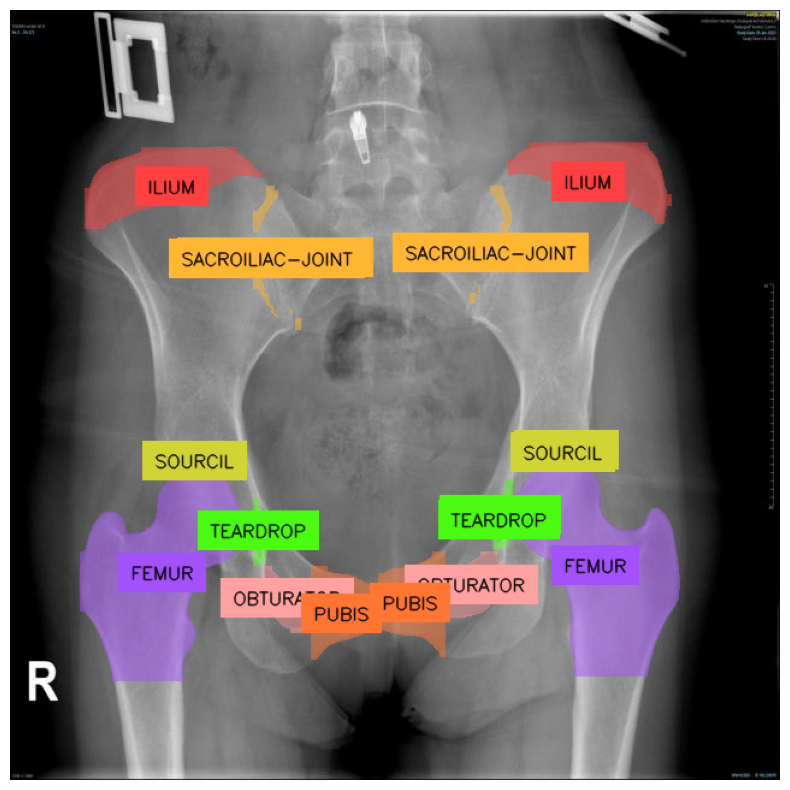

In [ ]:
mask_annotator = sv.MaskAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK, text_position=sv.Position.CENTER)

annotated_image = image.copy()
mask_annotator.annotate(annotated_image, detections=detections)
label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Deploy model on Roboflow

Once you have finished training your YOLOv11 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/segment/train/weights/best.pt` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv11 weights.

In [ ]:
project.version(dataset.version).deploy(model_type="yolov11-seg", model_path=f"{HOME}/runs/segment/train/")

In [ ]:
!pip install inference

In [ ]:
import os, random, cv2
import supervision as sv
import IPython
import inference

model_id = project.id.split("/")[1] + "/" + dataset.version
model = inference.get_model(model_id, userdata.get('ROBOFLOW_API_KEY'))

# Location of test set images
test_set_loc = dataset.location + "/test/images/"
test_images = os.listdir(test_set_loc)

# Run inference on 4 random test images, or fewer if fewer images are available
for img_name in random.sample(test_images, min(4, len(test_images))):
    print("Running inference on " + img_name)

    # Load image
    image = cv2.imread(os.path.join(test_set_loc, img_name))

    # Perform inference
    results = model.infer(image)[0]
    detections = sv.Detections.from_inference(results)

    # Annotate boxes and labels
    mask_annotator = sv.MaskAnnotator()
    label_annotator = sv.LabelAnnotator()
    annotated_image = mask_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Display annotated image
    _, ret = cv2.imencode('.jpg', annotated_image)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)


## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.